# 회귀를 이용한 자동차 연비 예측
- Auto MPG 데이터 세트를 이용해서 확률로 연속된 출력 값에 대해서 예측한다.
    - https://archive.ics.uci.edu/ml/datasets/auto+mpg
    - 70~80년대 자동차 연비 데이터
    - tf.keras API 를 이용해서 확률 값을 이용해 회귀로 연비를 예측한다.

### 데이터 세트
- Auto MPG 데이터 세트를 UCI 머신 러닝 저장소에서 다운로드

In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\BIT\\.keras\\datasets\\auto-mpg.data'

- Auto MPG 데이터 세트의 구성을 파악해 보자

In [2]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
na_values = "?", comment='\t',
sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


- Auto MPG 데이터 세트의 자료의 형식

In [3]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### 데이터 정제
- 일부 데이터가 누락 (Horsepower 6)

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 문제를 간단하게 만들기 위해서 누락된 행을 삭제

In [5]:
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- Origin 컬럼은 범주형이므로 수치화 자료로 인코딩

In [6]:
dataset.value_counts()

MPG   Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  Origin
46.6  4          86.0          65.0        2110.0  17.9          80          3         1
18.0  8          307.0         130.0       3504.0  12.0          70          1         1
18.1  6          258.0         120.0       3410.0  15.1          78          1         1
      8          302.0         139.0       3205.0  11.2          78          1         1
18.2  8          318.0         135.0       3830.0  15.2          79          1         1
                                                                                      ..
27.0  4          97.0          88.0        2130.0  14.5          70          3         1
                                                                 71          3         1
                 101.0         83.0        2202.0  15.3          76          2         1
                 112.0         88.0        2640.0  18.6          82          1         1
9.0   8          304.0    

- Origin 컬럼은 범주형이므로 수치화 자료로 인코딩

In [7]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터 세트 분할
- 데이터를 훈련 세트와 테스트 세트로 분할

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

### 데이터 분포 조사
- 산점도 행렬을 통해 전체 분포를 파악

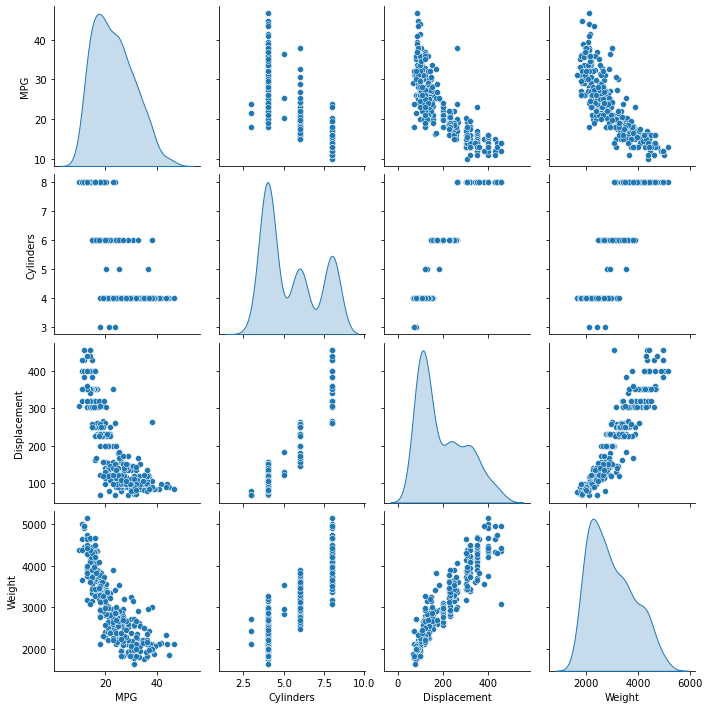

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

- 전반적인 통계 수치

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 특성과 레이블 분리
- 특성에서 타깃 값 또는 "레이블"을 분리
    - 레이블을 예측하기 위해 모델을 훈련

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 정규화
- 특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장
- train_stats 통계에서 각 특성의 범위의 차이

In [12]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 모델
- 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델
- 나중 새 모델을 만들기 쉽도록 build_model 함수 구현

In [13]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])

    return model

- 모델을 구성하고 .summary 메서드를 사용해 모델에 대한 간단한 정보를 출력

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


- 구성된 모델에서 훈련 세트에서 10 샘플을 하나의 배치로 만들어 예측

In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1328776 ],
       [-0.01901789],
       [-0.26439142],
       [ 0.14957036],
       [ 0.4295074 ],
       [ 0.03362917],
       [ 0.41252375],
       [ 0.18749505],
       [-0.05470008],
       [ 0.33409902]], dtype=float32)

### 모델 훈련
- 이 모델을 1,000번의 에포크(epoch) 동안 훈련
    - 훈련 정확도와 검증 정확도는 history 객체에 기록

In [17]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

- history 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.320768,1.026615,2.320767,9.771308,2.443511,9.771308,995
996,2.307628,0.962547,2.307628,10.322425,2.510219,10.322425,996
997,2.351998,1.023096,2.351998,9.266310,2.360799,9.266311,997
998,2.401388,0.997402,2.401388,10.031251,2.418702,10.031250,998
999,2.410561,1.041513,2.410561,9.858026,2.366337,9.858027,999


- history 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

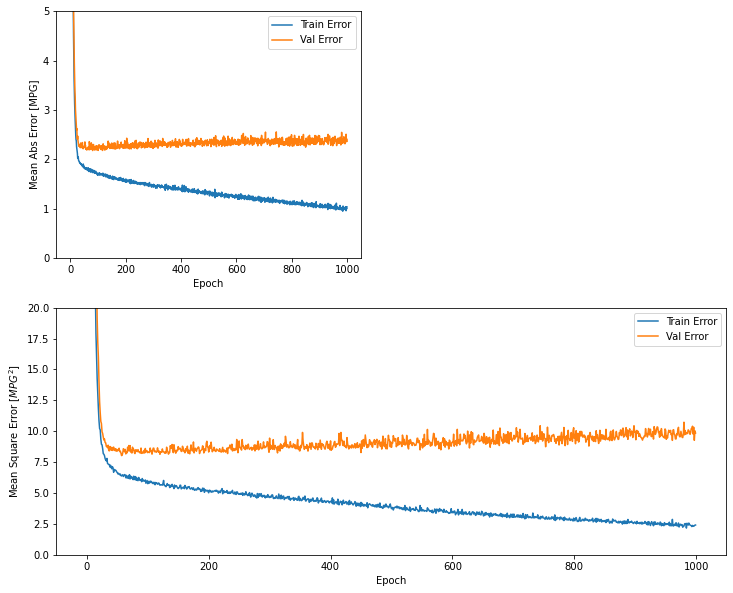

In [19]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(12,10))
    
    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
plot_history(history)

- Callback 을 사용해 자동으로 훈련 종료


.................................................................

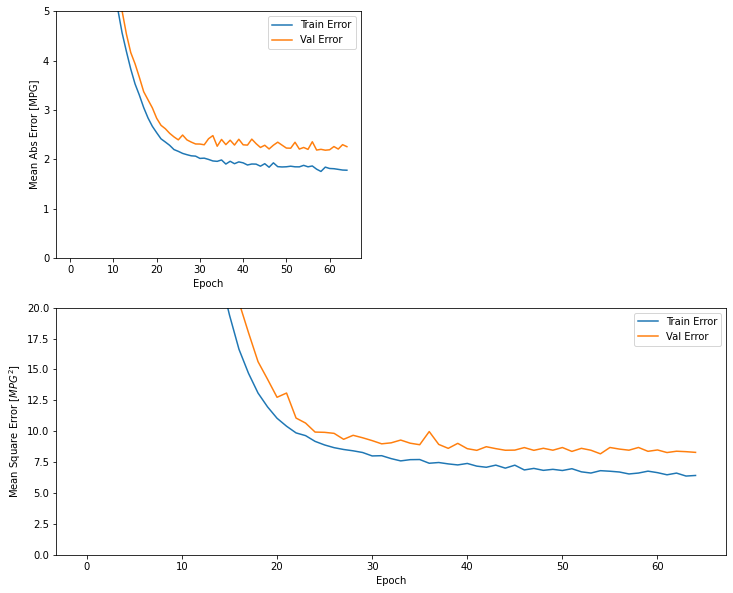

In [20]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

- 테스트 세트에서 모델의 성능을 확인
    - 모델이 실전에 투입되었을 때 모델의 성능을 짐작

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.9874 - mae: 1.8949 - mse: 5.9874
테스트 세트의 평균 절대 오차:  1.89 MPG


### 예측
- 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측

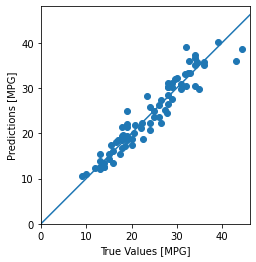

In [22]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

- 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측

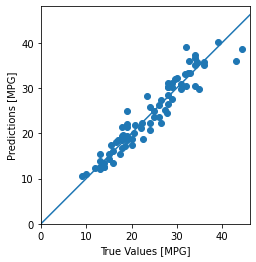

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

- 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측
    - 오차의 분포

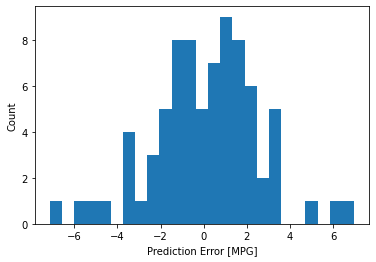

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### 결론
- 회귀 문제를 풀기 위한 기법을 소개
    - 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수. (분류 문제의 손실 함수와 다르다).
    - 회귀에서 사용되는 평가 지표도 분류와 다르다. 많이 사용하는 회귀 평가 지표는 평균 절댓값 오차(MAE)
    - 수치 입력 데이터의 특성이 여러 가지 범위는 동일한 범위로 각 특성의 스케일을 독립적으로 조정해야 한다.
    - 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋다.
    - 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법이다.